In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

In [2]:
# загрузим данные
df = pd.read_csv('data/segmented_customers.csv')
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [3]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [4]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [5]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [6]:
df.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [7]:
import plotly
import plotly.express as px

In [8]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [9]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [10]:
X = df[['age', 'annual_income', 'spending_score']]

In [12]:
# Импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN
import seaborn as sns

In [13]:
# Запускаем кластеризацию на наших данных
clustering = DBSCAN().fit(X)

In [15]:
res = clustering.fit_predict(X)

In [16]:
df['dbscan_res'] = res

In [17]:
get_3d_visualization(df, 'dbscan_res')

In [29]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

In [30]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

In [31]:
# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agglomerative_clustering.fit(X)
    aggl_prediction = agglomerative_clustering.labels_
    return aggl_prediction

In [33]:
res_2 = get_aggl_clustering(X, 3)

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

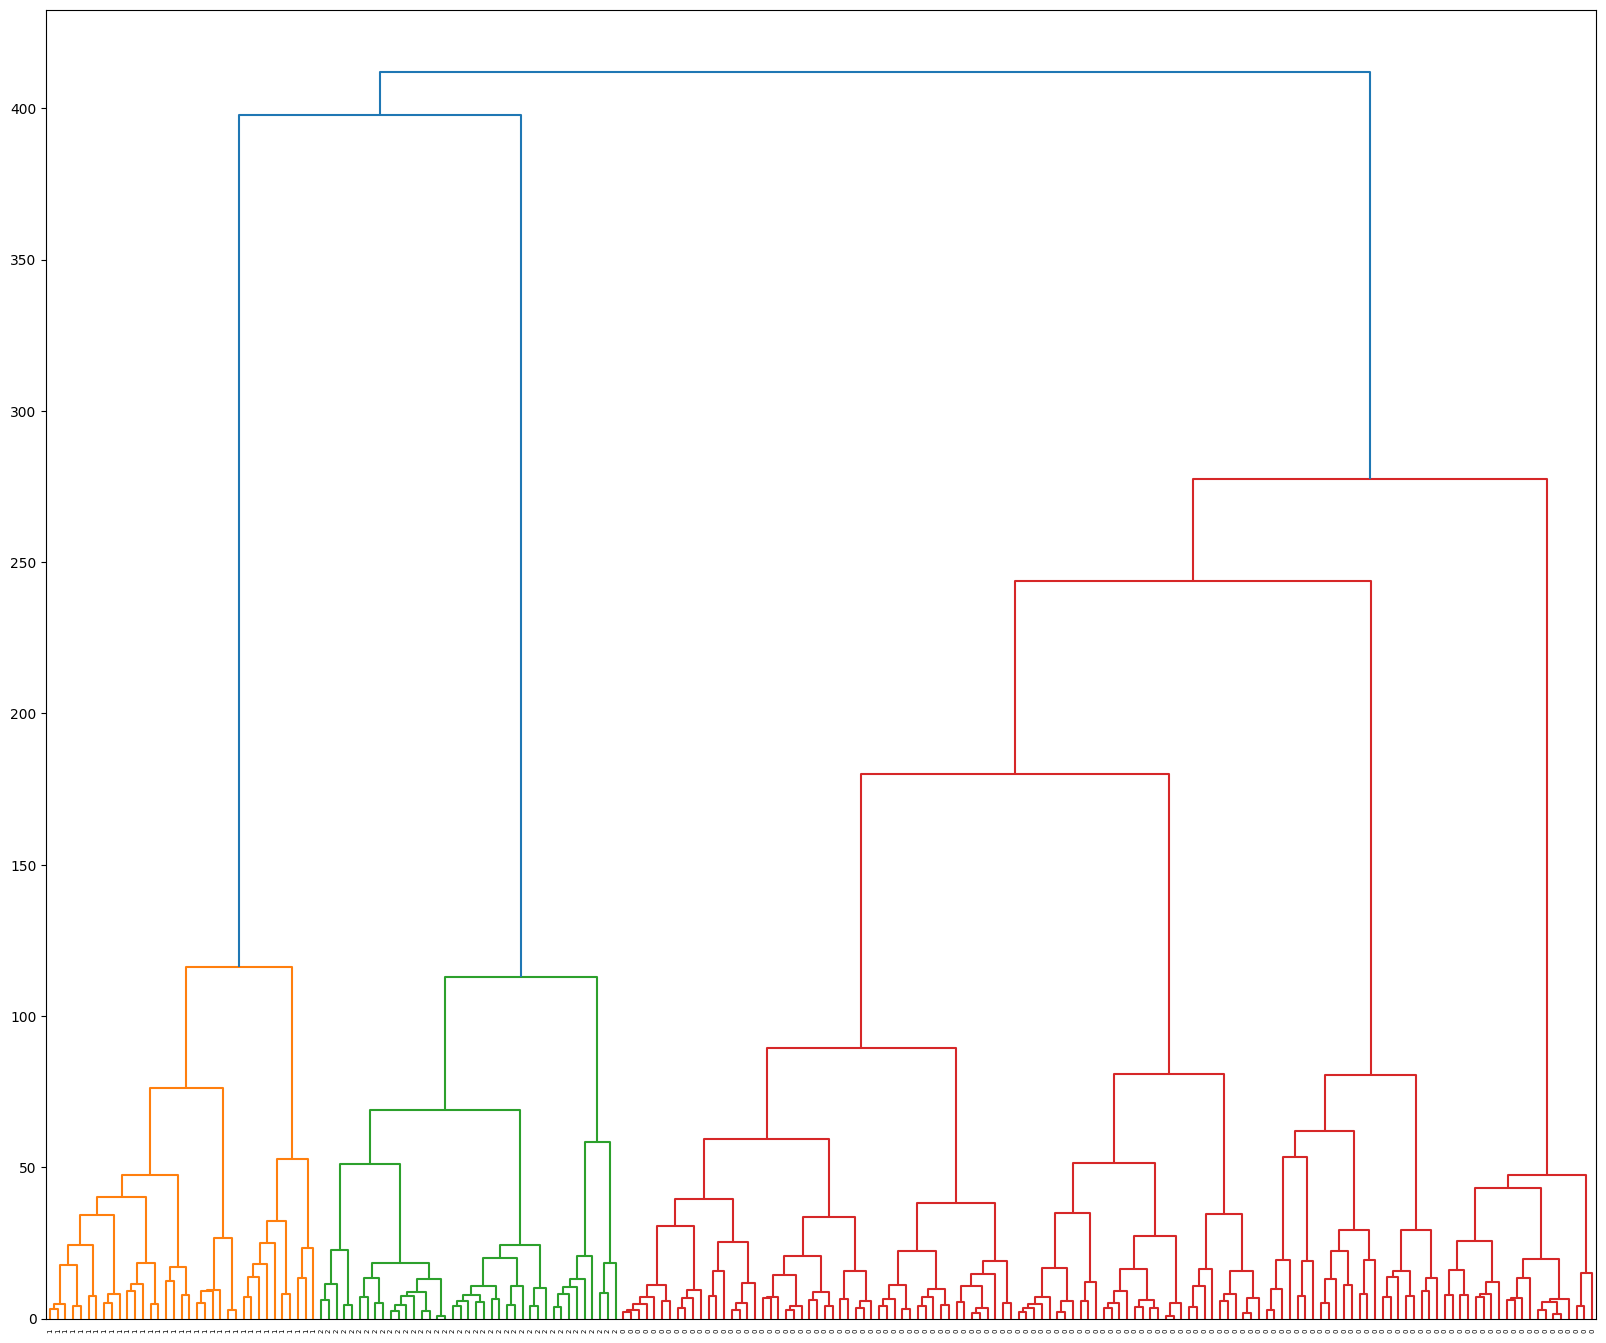

In [35]:
# рассчитаем расстояния между кластерами
linked = linkage(X, 'ward')

plt.figure(figsize=(20, 17))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=res_2,
            distance_sort='descending')

plt.show()

In [36]:
df['aggl_res_6'] = get_aggl_clustering(X, 6)
get_3d_visualization(df, 'aggl_res_6')

In [37]:
from sklearn.metrics import silhouette_score

In [38]:
# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    res = get_aggl_clustering(X, cluster_num)
    silhouette = silhouette_score(X, res)
    return silhouette

In [39]:
# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

In [43]:
for i in range(2, 10):
    silhouette_res['silhouette'].append(get_silhouette_agg_clust(X, i))
    silhouette_res['cluster'].append(i)

In [46]:
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

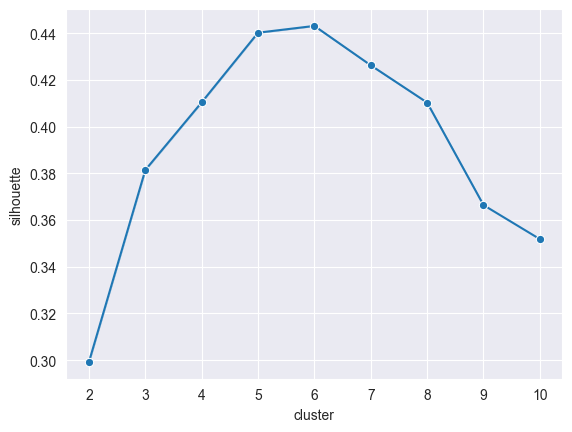

In [48]:
# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df[silhouette_df['cluster'] <= 10], x="cluster", y="silhouette", marker="o")

In [52]:
from sklearn.metrics.cluster import completeness_score

print(round(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6), 2))

0.9
